In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import os
import sys
from pathlib import Path

PROJ_ROOT = str(
    Path(os.getcwd()).parent.parent
)  # add project root file to the python paths
sys.path.append(PROJ_ROOT)

In [12]:
import torch

from config.model_config import ModelConfig
from config.experiment_config import ExperimentConfig, AvailableDatasets
from vol_predict.features.preprocessor import OneToOnePreprocessor

from vol_predict.models.dl.mlp_predictor import MLPPredictor as Model
# from vol_predict.models.baselines.naive_predictor import NaivePredictor as Baseline
from vol_predict.models.baselines.ewma_predictor import EWMAPredictor as Baseline


from run import initialize_runner, run_backtest

In [13]:
config = ExperimentConfig()
config.DATASET = AvailableDatasets.SPX
config.ASSET_UNIVERSE = ("spx",)

model_params = ModelConfig()
baseline_params = ModelConfig()

# Handles the features
feature_processor = OneToOnePreprocessor()

runner = initialize_runner(
    model_config=model_params,
    preprocessor=feature_processor,
    experiment_config=config,
)

Train data on 2004-03-23 00:00:00 to 2020-12-31 00:00:00
Test data on 2022-01-04 00:00:00 to 2025-01-28 00:00:00
Num Train Iterations: 4225
Num Features: 23


# Exponentially Weighted Moving Average (EWMA)

$$
\hat{y}_t = \alpha \sum_{i=1}^T \beta^{t-i} y_{t-i}
$$

where:
- $\hat{y}_t$ is the forecast for time $t$
- $y_{t}$ is the observed value at time $t$ 
- $\alpha$ is the normalization factor,  `normlaization_factor` in code
- $\beta$ is the forgetting factor (0 < $\beta$ < 1), `forgetting_factor`
- $T$ is the number of observations, `ewma_look_back_win` 

Optimization is done on a `raw_forgetting_factor` which is on $\mathbb{R}$, mapping is done as
`forgetting_factor = torch.sigmoid(raw_forgetting_factor)`. The interpretable value of the forgetting factor is the half-life, and the method `EWMAPredictor.get_half_life()`  returns the half-life.

In [14]:
training_data_sample = runner.train_data

In [15]:
training_data_sample

,10y,BEST_EPS,CORR_COEF,DVD_PAYOUT_RATIO,DVD_SH_LAST,NET_AGGTE_DVD_YLD,NET_DEBT_TO_EBITDA,PE_RATIO,PX_TO_BOOK_RATIO,SHORT_AND_LONG_TERM_DEBT,...,erp,est_pe,global_bonds_total_r,inflation_total_r,libor3m,sentiment,spread,spx,tail,ts
date,,,,,,,,,,,,,,,,,,,,,
2004-03-23,-0.015487,0.000266,0.000100,0.000000,0.015004,0.012422,0.000000,-0.012958,-0.012955,0.000000,...,-0.019448,-0.012958,0.002957,0.005008,0.000000,0.000000,1.227273,-0.012958,-0.009000,-0.010733
2004-03-24,-0.006060,0.001242,-0.000060,0.000000,0.000000,0.000000,0.000000,-0.001323,-0.001339,0.000000,...,-0.002852,-0.001324,-0.001562,-0.000760,0.000000,0.000000,-0.734694,-0.001324,-0.001816,-0.002406
2004-03-25,0.004553,0.000204,-0.000002,0.000000,0.004144,0.006135,0.000000,-0.002396,-0.002387,0.000000,...,0.000000,-0.002395,-0.001027,-0.001592,0.000000,0.000000,1.076923,-0.002395,-0.002224,0.009065
2004-03-26,0.008066,0.001035,0.000065,-0.000652,0.000000,-0.018293,0.001698,0.016663,0.015108,0.002147,...,0.016771,0.016365,-0.001236,-0.004365,0.000000,-0.184456,1.111111,0.016365,0.011348,0.006375
2004-03-29,0.024727,0.000299,-0.000003,0.000000,0.000321,0.000000,0.000000,-0.001016,-0.001033,0.000000,...,0.011380,-0.001019,-0.004549,-0.003839,0.000000,0.000000,-1.035088,-0.001019,-0.002204,-0.003840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.029027,0.000064,-0.000036,0.000000,0.056260,-0.006211,0.000000,0.000745,0.000735,0.000000,...,0.006752,0.000746,-0.000353,-0.004058,0.054046,0.000000,-0.138959,0.000746,-0.000827,0.025745
2020-12-28,-0.021103,-0.000066,-0.000004,0.000000,0.290584,0.000000,0.000000,0.003538,0.003548,0.000000,...,-0.000331,0.003537,0.000851,0.002977,-0.043307,0.004608,0.537733,0.003537,0.002098,-0.021835
2020-12-29,0.000000,-0.000006,-0.000312,0.000000,0.000000,-0.012500,0.000000,0.008721,0.008729,0.000000,...,0.008862,0.008723,-0.000271,-0.000982,0.000000,0.000000,-0.176121,0.008723,0.007019,-0.002525


In [16]:
spx_tensor = torch.Tensor(training_data_sample.spx)

/tmp/ipykernel_388780/310214587.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spx_tensor = torch.Tensor(training_data_sample.spx)


In [17]:
Baseline

vol_predict.models.baselines.ewma_predictor.EWMAPredictor

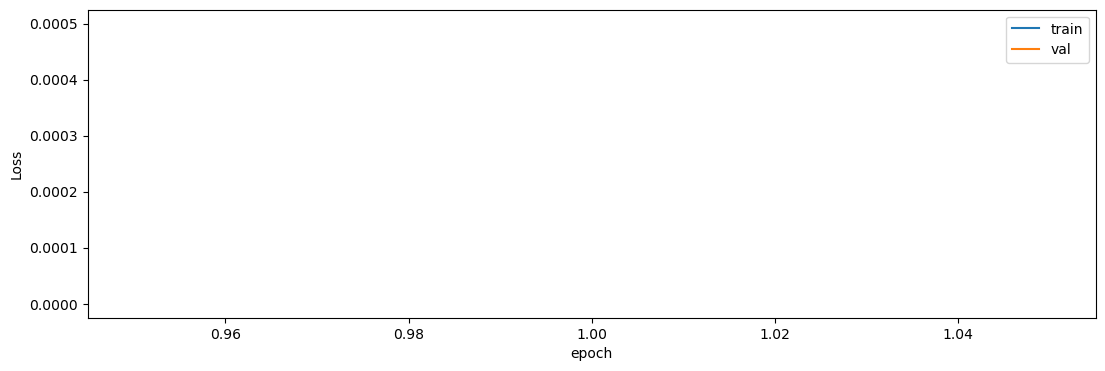

Training 1/1:   0%|          | 0/66 [00:00<?, ?it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Training 1/1:   0%|          | 0/66 [00:00<?, ?it/s]


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [18]:
model_params.n_epochs = 1
model_params.hidden_size = 64
model_params.n_features = 23 + 1
model_params.batch_size = 16
model_params.lr = 1e-2
model_params.optimizer = torch.optim.Adam

baseline_params.n_epochs = 1
baseline_params.ewma_look_back_win = 21
baseline_params.ewma_vola_calc_win = 21

result = run_backtest(
    model_cls=Model,
    baseline_cls=Baseline,
    model_config=model_params,
    baseline_config=baseline_params,
    runner=runner,
)